In [ ]:
!pip install -q tensorflow


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

In [ ]:
# Load data
df = pd.read_csv("/content/ARTO.JK_stock_data (2).csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

In [ ]:
# Gunakan hanya fitur numerik untuk prediksi
features = ['Close', 'Open', 'High', 'Low', 'Volume']
data = df[features]

In [ ]:
# Normalisasi data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [ ]:
# Fungsi untuk membuat window time-series
def create_dataset(dataset, window_size=30):
    X, y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:i+window_size])
        y.append(dataset[i+window_size, 0])  # prediksi kolom Close
    return np.array(X), np.array(y)

window_size = 30
X, y = create_dataset(data_scaled, window_size)

In [ ]:
# Gunakan KNN untuk memilih observasi yang mirip (opsional)
knn = NearestNeighbors(n_neighbors=200)
knn.fit(X.reshape((X.shape[0], -1)))
_, indices = knn.kneighbors(X.reshape((X.shape[0], -1)))
X_knn = X[indices[:, 0]]  # Ambil titik pusat
Y_knn = y[indices[:, 0]]

In [ ]:
# Split data untuk training dan testing
X_train, X_test, y_train, y_test = train_test_split(X_knn, Y_knn, test_size=0.2, shuffle=False)


In [ ]:
# Bentuk model LSTM
model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(window_size, X.shape[2])),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,251 (43.95 KB)

 Trainable params: 11,251 (43.95 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0313 - val_loss: 3.2060e-04
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.3436e-04 - val_loss: 1.9366e-04
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.3934e-04 - val_loss: 1.4347e-04
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.0709e-04 - val_loss: 1.2908e-04
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.9176e-04 - val_loss: 1.0287e-04
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.7205e-04 - val_loss: 9.2590e-05
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.8194e-04 - val_loss: 7.4732e-05
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.6486e-04 - val_loss: 8.9392e-05
Epoch 9/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.5856e-04 - val_loss: 7.9913e-05
Epoch 10/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.3060e-04 - val_loss: 7.6106e-05
Epoch 11/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1559e-04 - val_loss

In [ ]:
# Prediksi dan visualisasi
y_pred = model.predict(X_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


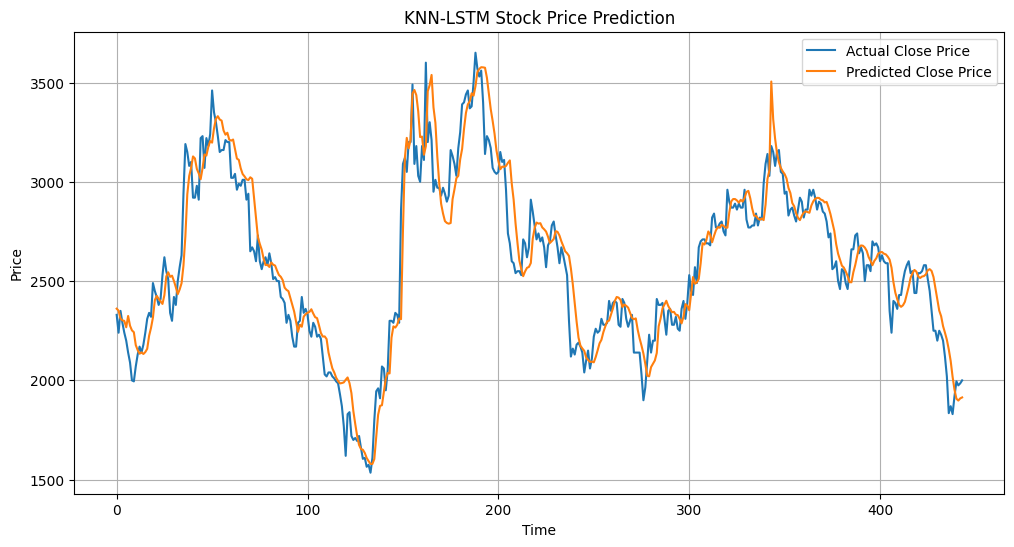

In [ ]:
# Invers transform hasil
close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler.min_[0], scaler.scale_[0]
y_pred_rescaled = y_pred * scaler.data_range_[0] + scaler.data_min_[0]
y_test_rescaled = y_test * scaler.data_range_[0] + scaler.data_min_[0]

plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual Close Price')
plt.plot(y_pred_rescaled, label='Predicted Close Price')
plt.title('KNN-LSTM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()
